# Titanic EDA — Overview

Exploratory data analysis for the Kaggle Titanic dataset. This notebook:
- Loads `data/train.csv` and `data/test.csv`.
- Summarizes structure, missingness, and target distribution.
- Visualizes key relationships with survival (by `Sex`, `Pclass`, `Age`, `Fare`, `Embarked`).
- Surfaces simple engineered signals (e.g., `FamilySize`) to guide modeling.

Run all cells top-to-bottom. Plots use seaborn/matplotlib.

In [5]:
# Imports and setup
from __future__ import annotations

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import seaborn as sns

    sns.set_theme(style="whitegrid")
except Exception:
    sns = None

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.options.display.max_columns = 100
pd.options.display.width = 120

DATA_TRAIN = '../data/train.csv'
DATA_TEST = '../data/test.csv'

## Load Data

In [6]:
train = pd.read_csv(DATA_TRAIN)
test = pd.read_csv(DATA_TEST)
len(train), len(test), train.columns.tolist()

(891,
 418,
 ['PassengerId',
  'Survived',
  'Pclass',
  'Name',
  'Sex',
  'Age',
  'SibSp',
  'Parch',
  'Ticket',
  'Fare',
  'Cabin',
  'Embarked'])

## Basic Structure

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [9]:
train.dtypes.to_frame('dtype')

,dtype
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


## Missingness

In [10]:
missing = train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0].to_frame('missing')
missing['pct'] = (missing['missing'] / len(train) * 100).round(2)
missing

,missing,pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


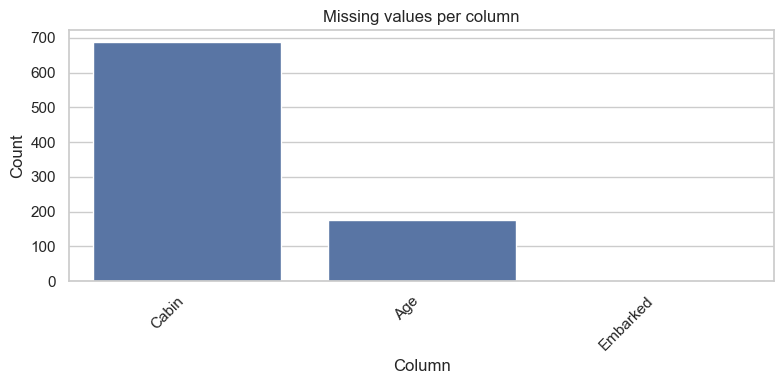

In [11]:
if sns is not None and not missing.empty:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=missing.index, y=missing['missing'], color="#4C72B0")
    plt.title('Missing values per column')
    plt.ylabel('Count')
    plt.xlabel('Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    missing


## Target Distribution (`Survived`)

In [12]:
target_col = 'Survived'
train[target_col].value_counts().to_frame('count').assign(pct=lambda d: (d['count'] / len(train)).round(3))

,count,pct
Survived,,
0,549,0.616
1,342,0.384


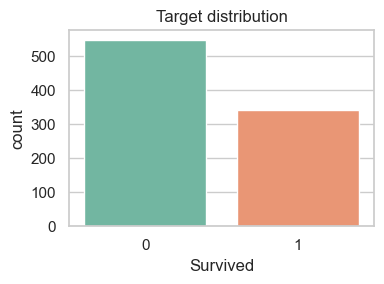

In [13]:
if sns is not None:
    plt.figure(figsize=(4, 3))
    sns.countplot(x=target_col, data=train, palette="Set2")
    plt.title('Target distribution')
    plt.tight_layout()
    plt.show()


## Univariate Distributions

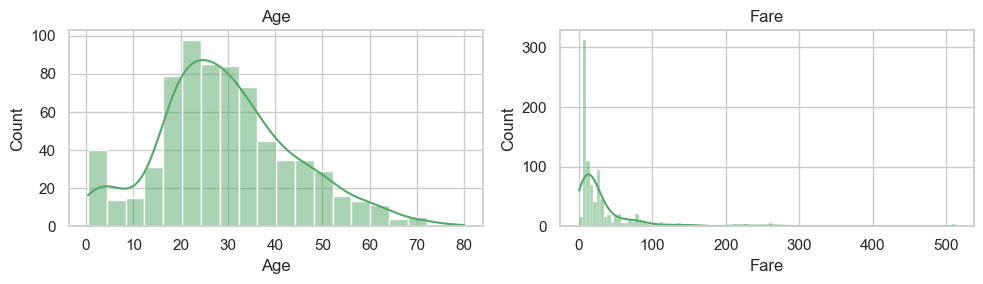

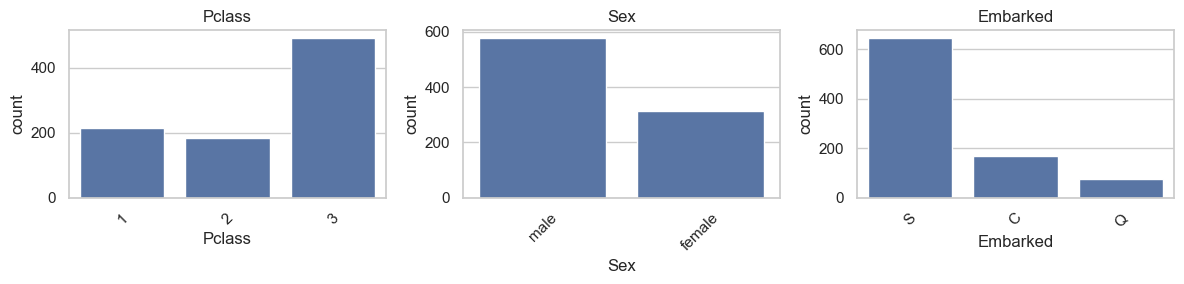

In [14]:
num_cols = ['Age', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked']

if sns is not None:
    fig, axes = plt.subplots(1, len(num_cols), figsize=(10, 3))
    for ax, col in zip(axes, num_cols):
        sns.histplot(train[col], kde=True, ax=ax, color="#55A868")
        ax.set_title(col)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, len(cat_cols), figsize=(12, 3))
    for ax, col in zip(axes, cat_cols):
        sns.countplot(x=col, data=train, ax=ax, color="#4C72B0")
        ax.set_title(col)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    plt.tight_layout()
    plt.show()
else:
    train[num_cols + cat_cols].describe(include='all').T


## Survival by Key Features

In [15]:
def rate_by(col: str) -> pd.DataFrame:
    g = (train
         .groupby(col)['Survived']
         .agg(['mean', 'count'])
         .rename(columns={'mean': 'survival_rate'})
         .sort_values('survival_rate', ascending=False))
    return g


rate_by('Sex'), rate_by('Pclass'), rate_by('Embarked')


(        survival_rate  count
 Sex                         
 female       0.742038    314
 male         0.188908    577,
         survival_rate  count
 Pclass                      
 1            0.629630    216
 2            0.472826    184
 3            0.242363    491,
           survival_rate  count
 Embarked                      
 C              0.553571    168
 Q              0.389610     77
 S              0.336957    644)

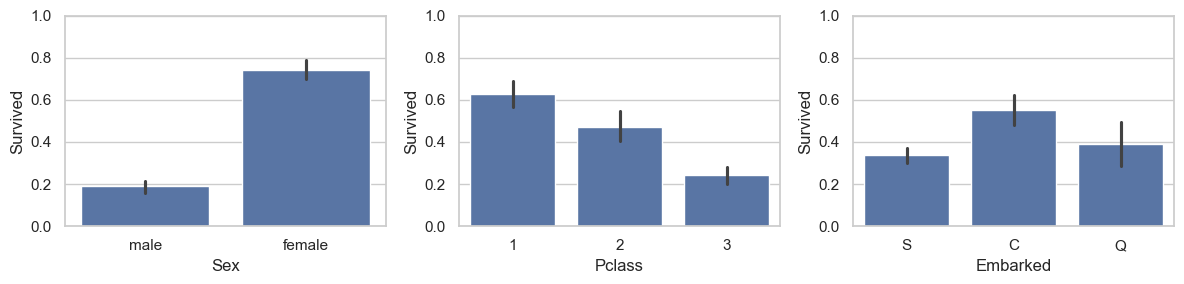

In [16]:
if sns is not None:
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    sns.barplot(x='Sex', y='Survived', data=train, ax=axes[0])
    sns.barplot(x='Pclass', y='Survived', data=train, ax=axes[1])
    sns.barplot(x='Embarked', y='Survived', data=train, ax=axes[2])
    for ax in axes:
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


## Age Bins and Survival

In [17]:
age_bins = pd.cut(train['Age'], bins=[0, 5, 12, 18, 30, 45, 60, 80], include_lowest=True)
age_rates = train.assign(AgeBin=age_bins).groupby('AgeBin')['Survived'].mean().to_frame('survival_rate')
age_rates

,survival_rate
AgeBin,
"(-0.001, 5.0]",0.704545
"(5.0, 12.0]",0.360000
"(12.0, 18.0]",0.428571
"(18.0, 30.0]",0.355556
"(30.0, 45.0]",0.425743
"(45.0, 60.0]",0.407407
"(60.0, 80.0]",0.227273


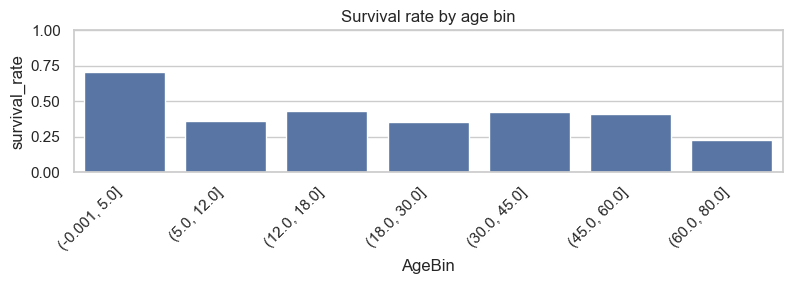

In [18]:
if sns is not None:
    plt.figure(figsize=(8, 3))
    sns.barplot(x=age_rates.index.astype(str), y=age_rates['survival_rate'])
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title('Survival rate by age bin')
    plt.tight_layout()
    plt.show()


## Simple Engineered Signals

In [19]:
fe = train.copy()
fe['FamilySize'] = fe['SibSp'] + fe['Parch'] + 1
fe['IsAlone'] = (fe['FamilySize'] == 1).astype(int)

family_rate = fe.groupby('FamilySize')['Survived'].mean().to_frame('survival_rate')
isalone_rate = fe.groupby('IsAlone')['Survived'].mean().to_frame('survival_rate')
family_rate.head(), isalone_rate


(            survival_rate
 FamilySize               
 1                0.303538
 2                0.552795
 3                0.578431
 4                0.724138
 5                0.200000,
          survival_rate
 IsAlone               
 0             0.505650
 1             0.303538)

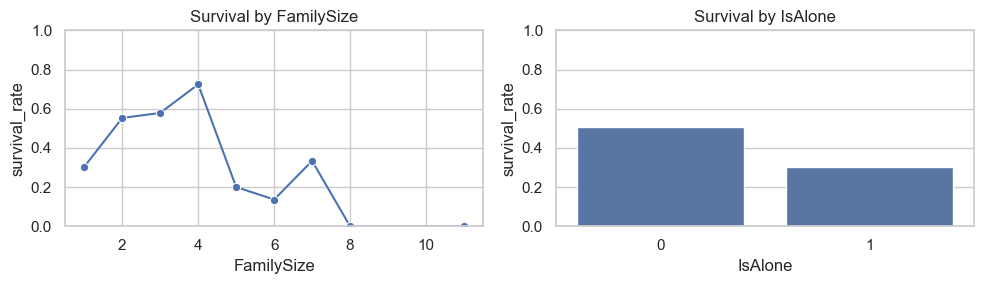

In [20]:
if sns is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.lineplot(x=family_rate.index, y=family_rate['survival_rate'], marker='o', ax=axes[0])
    axes[0].set_title('Survival by FamilySize')
    axes[0].set_ylim(0, 1)
    sns.barplot(x=isalone_rate.index.astype(str), y=isalone_rate['survival_rate'], ax=axes[1])
    axes[1].set_title('Survival by IsAlone')
    axes[1].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


## Correlations (Numeric)

In [21]:
num_for_corr = train[['Survived', 'Age', 'Fare', 'SibSp', 'Parch']].copy()
corr = num_for_corr.corr()
corr

,Survived,Age,Fare,SibSp,Parch
Survived,1.000000,-0.077221,0.257307,-0.035322,0.081629
Age,-0.077221,1.000000,0.096067,-0.308247,-0.189119
Fare,0.257307,0.096067,1.000000,0.159651,0.216225
SibSp,-0.035322,-0.308247,0.159651,1.000000,0.414838
Parch,0.081629,-0.189119,0.216225,0.414838,1.000000


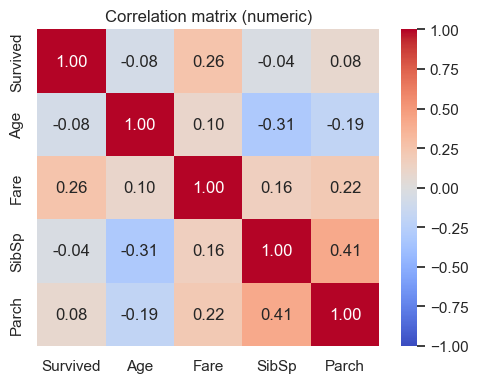

In [22]:
if sns is not None:
    plt.figure(figsize=(5, 4))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation matrix (numeric)')
    plt.tight_layout()
    plt.show()


## Age Outlier Analysis
df = pd.read_csv(DATA_TRAIN)

# Summary statistics
print('Summary statistics for Age:')
print(df['Age'].describe())

# List lowest and highest Age values
print('Lowest Age values:')
print(df['Age'].nsmallest(10))
print('Highest Age values:')
print(df['Age'].nlargest(10))

# Plot Age distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['Age'].hist(bins=30, edgecolor='black')
plt.title('Age Distribution (Histogram)')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df.boxplot(column='Age')
plt.title('Age Distribution (Boxplot)')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

# Flag potential outliers
q1 = df['Age'].quantile(0.25)
q3 = df['Age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df[(df['Age'] < lower_bound) | (df['Age'] > upper_bound)]
print(f'Potential Age outliers (outside {lower_bound:.2f} - {upper_bound:.2f}):')
print(outliers[['PassengerId', 'Age']])


## Notes
- Strong survival differences by `Sex` and `Pclass`.
- Non-linear effects in `Age` bins (children higher survival).
- `FamilySize` and `IsAlone` show signal; may help simple models.
- Handle missing values (`Age`, `Cabin`, `Embarked`) in preprocessing.
- Consider extracting `Title` from `Name` and deck from `Cabin`.
